In [1]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import keras
import tensorflow as tf
import xgboost as xgb
sns.set_palette('Set2')

Using TensorFlow backend.


In [2]:
#Importing Data & replacing space with underscore in columns' names

orig_data = pd.read_excel("OppScrData.xlsx")
for col in orig_data.columns:
    new_col = '_'.join(col.split())
    orig_data.rename(columns={col:new_col}, inplace=True)

# Predicting Death

In [3]:
# Preprocessing

data = orig_data.copy()

data['days'] = data['DEATH_[d_from_CT]']

data['BMI_>30'] = np.where(data['BMI_>30']=='Y', 1, 0)
data.rename(columns={'BMI_>30':'BMI_more_than_30'}, inplace=True)
data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

data['Alcohol_abuse'] = np.where(data['Alcohol_abuse'].isna(),0,1)

col = 'FRS_10-year_risk_(%)'
data[col] = data[col].astype(str)
data[col] = data[col].str.replace('X','')
data[col] = data[col].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data[col] = data[col].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)
med = data[col].median()
data[col] = data[col].fillna(med)
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)

for col in ['FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)']:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace('_','')
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].astype(float)
    med = data[col].median()
    data[col] = data[col].fillna(med)
    upper_limit = data[col].quantile(0.95)
    data[col] = data[col].clip(upper_limit)

data['Met_Sx'] = np.where(data['Met_Sx']=='Y', 1, np.where(data['Met_Sx']=='N', 0, -1))


data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['MI'] = np.where(data['MI_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)

data['diabetes'] = np.where(data['Type_2_Diabetes_DX'].isna(), 0, 1)

data['L1_HU_BMD'] = data['L1_HU_BMD'].clip(lower=0)
data['TAT/Body_Area'] = data['TAT_Area_(cm2)']/data['Total_Body_Area_EA_(cm2)']
col = 'VAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'SAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'VAT/SAT_Ratio'
upper_limit = data[col].quantile(0.95)
data[col] = data[col].clip(upper_limit)

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())
                          
for col in ['BMI','L1_HU_BMD','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
            'VAT/SAT_Ratio','Muscle_HU','Muscle_Area_(cm2)','L3_SMI_(cm2/m2)','TAT/Body_Area']:
    data[col] = data[col].fillna(data[col].median())

In [4]:
# Subsetting to columns in consideration

cols = ['Record_ID', 'BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
       'days', 'CVD', 'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

data = data[cols].copy()
print(data.isna().sum())

Record_ID                                  0
BMI                                        0
BMI_more_than_30                           0
Sex                                        0
Age_at_CT                                  0
Tobacco                                    0
Alcohol_abuse                              0
FRS_10-year_risk_(%)                       0
FRAX_10y_Fx_Prob_(Orange-w/_DXA)           0
FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)       0
Met_Sx                                     0
days                                    8674
CVD                                        0
Heart_failure                              0
MI                                         0
diabetes                                   0
L1_HU_BMD                                  0
TAT_Area_(cm2)                             0
Total_Body_Area_EA_(cm2)                   0
TAT/Body_Area                              0
VAT_Area_(cm2)                             0
SAT_Area_(cm2)                             0
VAT/SAT_Ra

In [5]:
# Creating "Recency" column

data = data[~(data['days']<0)]
data['days_recency'] = np.where(data['days']==0, 1,
                              np.where(data['days']>0, 1/data['days'],
                                       0))
print(orig_data.shape, data.shape)

(9223, 115) (9223, 29)


In [7]:
# Creating Train and Test Data

train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]
print(train.shape)
print(test.shape)

(7363, 29)
(1860, 29)


(6944, 29)
(419, 29)


/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


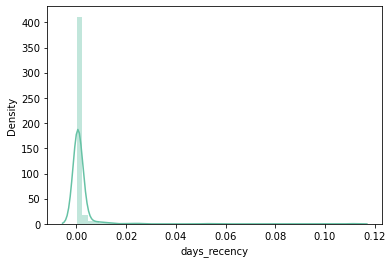

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


13.249765062538067
0.26471865408589695


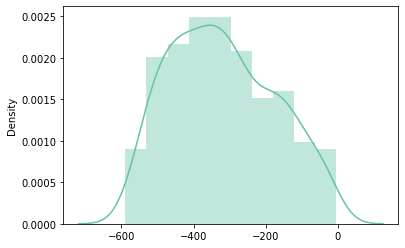

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


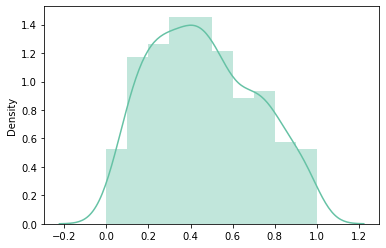

(419, 29) (419, 29) (838, 29)


/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='days_recency', ylabel='Density'>

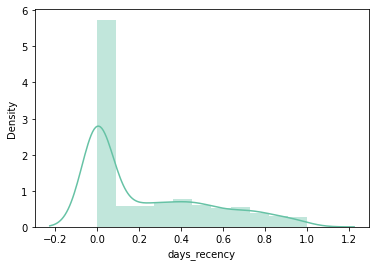

In [15]:
# Train Data: Applying Box-cox transform and Undersampling

col = 'days_recency'
train.sort_values(by=col, inplace=True)
train_1 = train[train[col].cumsum()==0]
train_2 = train[train[col].cumsum()>0]
print(train_1.shape)
print(train_2.shape)

from scipy import stats
X = train_2[col].copy()
sns.distplot(X)
plt.show()
print(pd.Series(X).skew())
X, paras = stats.boxcox(X)
print(pd.Series(X).skew())
sns.distplot(X)
plt.show()
X_mn = X.min()
X_mx = X.max()
Y = (X - X_mn)/(X_mx - X_mn)
sns.distplot(Y)
plt.show()
train_2[col] = Y

train_1_1 = train_1.sample(train_2.shape[0])
train = pd.concat([train_1_1, train_2], ignore_index=True)
train.reset_index(drop=True, inplace=True)
print(train_1_1.shape, train_2.shape, train.shape)
sns.distplot(train[col])

(1730, 29)
(130, 29)
(1730, 29) (130, 29) (1860, 29)


/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

<AxesSubplot:xlabel='days_recency', ylabel='Density'>

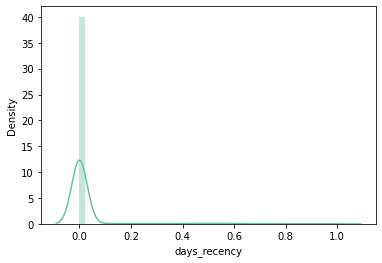

In [18]:
# Test Data: Applying Box-cox transform using parameters of Train

col = 'days_recency'
test.sort_values(by=col, inplace=True)
test_1 = test[test[col].cumsum()==0]
test_2 = test[test[col].cumsum()>0]
print(test_1.shape)
print(test_2.shape)

X = test[col].copy()
X = test_2[col].copy()
X = stats.boxcox(X, paras)
X_mn = X.min()
X_mx = X.max()
Y = (X - X_mn)/(X_mx - X_mn)
test_2[col] = Y

test = pd.concat([test_1, test_2], ignore_index=True)
test.reset_index(drop=True, inplace=True)
print(test_1.shape, test_2.shape, test.shape)
sns.distplot(test[col])

In [ ]:
type_of_feats = 'CT_and_clinical'

if type_of_feats=='only_CT':
    feats = ['L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']
else:
    feats = ['BMI', 'BMI_more_than_30',
       'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)',
       'FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CVD',
       'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']
    
# Define Label
label = 'days_recency'

In [20]:
# Create Train and Test numpy arrays

X_train = train[feats].values
Y_train = train[label].values
X_test = test[feats].values
Y_test = test[label].values
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(838, 26) (838,)
(1860, 26) (1860,)


### Linear Regression

In [11]:
model = LinearRegression().fit(X_train, Y_train)

### SVR

In [17]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

### XGBoost

In [ ]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]
model = xgb.XGBRegressor(n_estimators=500, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
model.fit(X_train, Y_train, eval_metric='rmse', eval_set=eval_set)

In [ ]:
# Plot Training and Test loss while training

sns.set_palette('Set2')
results = model.evals_result()
eval_metric = list(results['validation_0'].keys())[0]
epochs = len(results['validation_0'][eval_metric])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0'][eval_metric], label='Train Data', linewidth=2.5)
ax.plot(x_axis, results['validation_1'][eval_metric], label='Test Data', linewidth=2.5)
ax.legend()
plt.xlabel('No. of Iterations')
plt.ylabel('RMSE')
plt.title('Model training History')
plt.savefig('./Images/predictingRecency_XGB_trainingHistory.png')
plt.show()

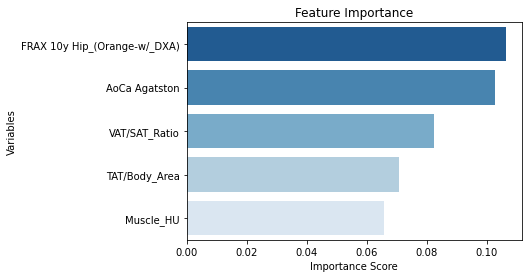

In [32]:
# Plot Feature importance

variables_df = pd.DataFrame(feats, columns=['Variables'])
importance_score_df = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
feature_imp = pd.concat([variables_df, importance_score_df], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
feature_imp = feature_imp.reset_index()
x = 'Importance Score'
y = 'Variables'
sns.barplot(x=x, y=y, data=feature_imp[:5], orient="h", palette="Blues_r")
plt.title('Feature Importance')
plt.savefig('./Images/predictingRecency_XGB_FeatImp.png')
plt.show()

In [ ]:
# Calculate RMSE on Test data

preds = model.predict(X_test).flatten()
rmse = math.sqrt(mean_squared_error(Y_test, preds))
print(rmse)

Error% for Non-zero values: 0.7092


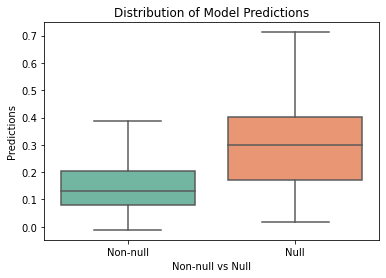

In [52]:
# Plot range of predictions for Null and Non-null sammples
y_nz = tmp_df[tmp_df['Y_test']!=0]['Y_test']
preds_nz = tmp_df[tmp_df['Y_test']!=0]['preds']
rmse = math.sqrt(mean_squared_error(y_nz, preds_nz))
print("Error% for Non-zero values: {:0.4f}".format((rmse/y_nz.mean())))

tmp_df['Y_test_cat'] = np.where(tmp_df['Y_test']!=0, "Null", "Non-null")
tmp_df.rename(columns={'Y_test_cat':'Non-null vs Null','preds':'Predictions'}, inplace=True)
sns.boxplot(data=tmp_df, x='Non-null vs Null', y='Predictions', order=["Non-null", "Null"], showfliers=False)
plt.title('Distribution of Model Predictions')

# plt.savefig('./Images/predictingRecency_XGB_nullVSnonnull.png')

## Predicting Heart Attack

In [3]:
# Preprocessing

data = orig_data.copy()

data['days'] = data['MI_DX_Date_[d_from_CT]']

data['BMI_>30'] = np.where(data['BMI_>30']=='Y', 1, 0)
data.rename(columns={'BMI_>30':'BMI_more_than_30'}, inplace=True)
data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

data['Alcohol_abuse'] = np.where(data['Alcohol_abuse'].isna(),0,1)

col = 'FRS_10-year_risk_(%)'
data[col] = data[col].astype(str)
data[col] = data[col].str.replace('X','')
data[col] = data[col].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data[col] = data[col].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)
med = data[col].median()
data[col] = data[col].fillna(med)
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)

for col in ['FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)']:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace('_','')
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].astype(float)
    med = data[col].median()
    data[col] = data[col].fillna(med)
    upper_limit = data[col].quantile(0.95)
    data[col] = data[col].clip(upper_limit)

data['Met_Sx'] = np.where(data['Met_Sx']=='Y', 1, np.where(data['Met_Sx']=='N', 0, -1))


data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['MI'] = np.where(data['MI_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)

data['diabetes'] = np.where(data['Type_2_Diabetes_DX'].isna(), 0, 1)

data['L1_HU_BMD'] = data['L1_HU_BMD'].clip(lower=0)
data['TAT/Body_Area'] = data['TAT_Area_(cm2)']/data['Total_Body_Area_EA_(cm2)']
col = 'VAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'SAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'VAT/SAT_Ratio'
upper_limit = data[col].quantile(0.95)
data[col] = data[col].clip(upper_limit)

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())
                          
for col in ['BMI','L1_HU_BMD','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
            'VAT/SAT_Ratio','Muscle_HU','Muscle_Area_(cm2)','L3_SMI_(cm2/m2)','TAT/Body_Area']:
    data[col] = data[col].fillna(data[col].median())

In [4]:
# Subsetting to columns in consideration

cols = ['Record_ID', 'BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
       'days', 'CVD', 'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

data = data[cols].copy()
print(data.isna().sum())

Record_ID                                  0
BMI                                        0
BMI_more_than_30                           0
Sex                                        0
Age_at_CT                                  0
Tobacco                                    0
Alcohol_abuse                              0
FRS_10-year_risk_(%)                       0
FRAX_10y_Fx_Prob_(Orange-w/_DXA)           0
FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)       0
Met_Sx                                     0
days                                    8382
CVD                                        0
Heart_failure                              0
MI                                         0
diabetes                                   0
L1_HU_BMD                                  0
TAT_Area_(cm2)                             0
Total_Body_Area_EA_(cm2)                   0
TAT/Body_Area                              0
VAT_Area_(cm2)                             0
SAT_Area_(cm2)                             0
VAT/SAT_Ra

In [5]:
# Creating "Recency" column

data = data[~(data['days']<0)]
data['days_recency'] = np.where(data['days']==0, 1,
                              np.where(data['days']>0, 1/data['days'],
                                       0))

In [7]:
# Creating Train and Test Data

train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]
print(train.shape)
print(test.shape)

(7047, 29)
(1788, 29)


(6701, 29)
(346, 29)


/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


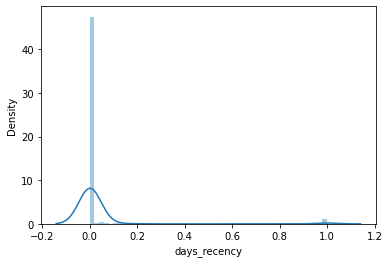

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


6.265168567152353
0.33525318393393777


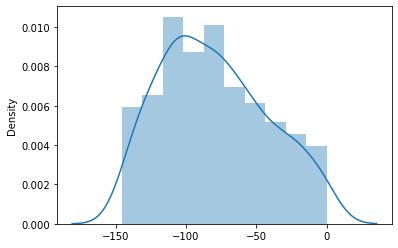

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


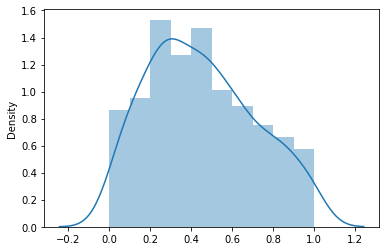

(346, 29) (346, 29) (692, 29)


/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='days_recency', ylabel='Density'>

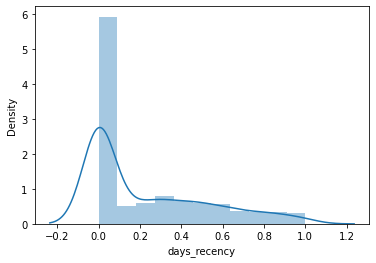

In [8]:
# Train Data: Applying Box-cox transform and Undersampling

col = 'days_recency'
train.sort_values(by=col, inplace=True)
train_1 = train[train[col].cumsum()==0]
train_2 = train[train[col].cumsum()>0]
print(train_1.shape)
print(train_2.shape)

from scipy import stats
X = train_2[col].copy()
sns.distplot(X)
plt.show()
print(pd.Series(X).skew())
X, paras = stats.boxcox(X)
print(pd.Series(X).skew())
sns.distplot(X)
plt.show()
X_mn = X.min()
X_mx = X.max()
Y = (X - X_mn)/(X_mx - X_mn)
sns.distplot(Y)
plt.show()
train_2[col] = Y

train_1_1 = train_1.sample(train_2.shape[0])
train = pd.concat([train_1_1, train_2], ignore_index=True)
train.reset_index(drop=True, inplace=True)
print(train_1_1.shape, train_2.shape, train.shape)
sns.distplot(train[col])

(1681, 29)
(107, 29)
(1681, 29) (107, 29) (1788, 29)


/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `d

<AxesSubplot:xlabel='days_recency', ylabel='Density'>

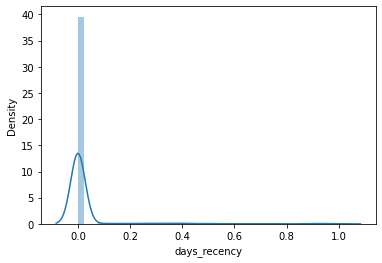

In [9]:
# Test Data: Applying Box-cox transform using parameters of Train

col = 'days_recency'
test.sort_values(by=col, inplace=True)
test_1 = test[test[col].cumsum()==0]
test_2 = test[test[col].cumsum()>0]
print(test_1.shape)
print(test_2.shape)
X = test[col].copy()
X = test_2[col].copy()
X = stats.boxcox(X, paras)
X_mn = X.min()
X_mx = X.max()
Y = (X - X_mn)/(X_mx - X_mn)
test_2[col] = Y
test = pd.concat([test_1, test_2], ignore_index=True)
test.reset_index(drop=True, inplace=True)
print(test_1.shape, test_2.shape, test.shape)
sns.distplot(test[col])

In [ ]:
type_of_feats = 'CT_and_clinical'

if type_of_feats=='only_CT':
    feats = ['L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']
else:
    feats = ['BMI', 'BMI_more_than_30',
       'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)',
       'FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CVD',
       'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']
    
# Define Label
label = 'days_recency'

In [ ]:
# Create Train and Test numpy arrays

X_train = train[feats].values
Y_train = train[label].values
X_test = test[feats].values
Y_test = test[label].values
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

### Linear Regression

In [18]:
model = LinearRegression().fit(X_train, Y_train)

### SVR

In [20]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

### XGBoost

In [22]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]
model = xgb.XGBRegressor(n_estimators=500, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
model.fit(X_train, Y_train, eval_metric='rmse', eval_set=eval_set)

[0]	validation_0-rmse:0.39710	validation_1-rmse:0.48665
[1]	validation_0-rmse:0.39427	validation_1-rmse:0.48366
[2]	validation_0-rmse:0.39143	validation_1-rmse:0.48073
[3]	validation_0-rmse:0.38864	validation_1-rmse:0.47783
[4]	validation_0-rmse:0.38587	validation_1-rmse:0.47497
[5]	validation_0-rmse:0.38316	validation_1-rmse:0.47212
[6]	validation_0-rmse:0.38047	validation_1-rmse:0.46931
[7]	validation_0-rmse:0.37785	validation_1-rmse:0.46654
[8]	validation_0-rmse:0.37526	validation_1-rmse:0.46383
[9]	validation_0-rmse:0.37270	validation_1-rmse:0.46114
[10]	validation_0-rmse:0.37010	validation_1-rmse:0.45840
[11]	validation_0-rmse:0.36753	validation_1-rmse:0.45571
[12]	validation_0-rmse:0.36498	validation_1-rmse:0.45303
[13]	validation_0-rmse:0.36251	validation_1-rmse:0.45039
[14]	validation_0-rmse:0.36001	validation_1-rmse:0.44778
[15]	validation_0-rmse:0.35760	validation_1-rmse:0.44521
[16]	validation_0-rmse:0.35517	validation_1-rmse:0.44268
[17]	validation_0-rmse:0.35280	validation

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[47]	validation_0-rmse:0.29210	validation_1-rmse:0.37816
[48]	validation_0-rmse:0.29034	validation_1-rmse:0.37648
[49]	validation_0-rmse:0.28858	validation_1-rmse:0.37482
[50]	validation_0-rmse:0.28686	validation_1-rmse:0.37323
[51]	validation_0-rmse:0.28508	validation_1-rmse:0.37162
[52]	validation_0-rmse:0.28336	validation_1-rmse:0.37002
[53]	validation_0-rmse:0.28165	validation_1-rmse:0.36844
[54]	validation_0-rmse:0.27999	validation_1-rmse:0.36692
[55]	validation_0-rmse:0.27835	validation_1-rmse:0.36537
[56]	validation_0-rmse:0.27669	validation_1-rmse:0.36385
[57]	validation_0-rmse:0.27514	validation_1-rmse:0.36237
[58]	validation_0-rmse:0.27362	validation_1-rmse:0.36096
[59]	validation_0-rmse:0.27206	validation_1-rmse:0.35950
[60]	validation_0-rmse:0.27053	validation_1-rmse:0.35811
[61]	validation_0-rmse:0.26899	validation_1-rmse:0.35669
[62]	validation_0-rmse:0.26742	validation_1-rmse:0.35535
[63]	validation_0-rmse:0.26599	validation_1-rmse:0.35403
[64]	validation_0-rmse:0.26446	

[190]	validation_0-rmse:0.15458	validation_1-rmse:0.26828
[191]	validation_0-rmse:0.15415	validation_1-rmse:0.26800
[192]	validation_0-rmse:0.15383	validation_1-rmse:0.26772
[193]	validation_0-rmse:0.15352	validation_1-rmse:0.26741
[194]	validation_0-rmse:0.15322	validation_1-rmse:0.26711
[195]	validation_0-rmse:0.15293	validation_1-rmse:0.26682
[196]	validation_0-rmse:0.15267	validation_1-rmse:0.26653
[197]	validation_0-rmse:0.15227	validation_1-rmse:0.26628
[198]	validation_0-rmse:0.15194	validation_1-rmse:0.26601
[199]	validation_0-rmse:0.15161	validation_1-rmse:0.26574
[200]	validation_0-rmse:0.15121	validation_1-rmse:0.26554
[201]	validation_0-rmse:0.15087	validation_1-rmse:0.26530
[202]	validation_0-rmse:0.15052	validation_1-rmse:0.26507
[203]	validation_0-rmse:0.15026	validation_1-rmse:0.26479
[204]	validation_0-rmse:0.14992	validation_1-rmse:0.26456
[205]	validation_0-rmse:0.14954	validation_1-rmse:0.26432
[206]	validation_0-rmse:0.14919	validation_1-rmse:0.26411
[207]	validati

[332]	validation_0-rmse:0.11815	validation_1-rmse:0.24837
[333]	validation_0-rmse:0.11803	validation_1-rmse:0.24830
[334]	validation_0-rmse:0.11788	validation_1-rmse:0.24825
[335]	validation_0-rmse:0.11773	validation_1-rmse:0.24819
[336]	validation_0-rmse:0.11739	validation_1-rmse:0.24813
[337]	validation_0-rmse:0.11707	validation_1-rmse:0.24808
[338]	validation_0-rmse:0.11695	validation_1-rmse:0.24802
[339]	validation_0-rmse:0.11680	validation_1-rmse:0.24797
[340]	validation_0-rmse:0.11665	validation_1-rmse:0.24793
[341]	validation_0-rmse:0.11658	validation_1-rmse:0.24788
[342]	validation_0-rmse:0.11643	validation_1-rmse:0.24783
[343]	validation_0-rmse:0.11622	validation_1-rmse:0.24777
[344]	validation_0-rmse:0.11607	validation_1-rmse:0.24772
[345]	validation_0-rmse:0.11599	validation_1-rmse:0.24769
[346]	validation_0-rmse:0.11585	validation_1-rmse:0.24764
[347]	validation_0-rmse:0.11564	validation_1-rmse:0.24758
[348]	validation_0-rmse:0.11536	validation_1-rmse:0.24756
[349]	validati

[474]	validation_0-rmse:0.09716	validation_1-rmse:0.24537
[475]	validation_0-rmse:0.09707	validation_1-rmse:0.24538
[476]	validation_0-rmse:0.09685	validation_1-rmse:0.24535
[477]	validation_0-rmse:0.09676	validation_1-rmse:0.24535
[478]	validation_0-rmse:0.09667	validation_1-rmse:0.24534
[479]	validation_0-rmse:0.09654	validation_1-rmse:0.24535
[480]	validation_0-rmse:0.09634	validation_1-rmse:0.24535
[481]	validation_0-rmse:0.09619	validation_1-rmse:0.24535
[482]	validation_0-rmse:0.09606	validation_1-rmse:0.24535
[483]	validation_0-rmse:0.09594	validation_1-rmse:0.24536
[484]	validation_0-rmse:0.09582	validation_1-rmse:0.24536
[485]	validation_0-rmse:0.09562	validation_1-rmse:0.24537
[486]	validation_0-rmse:0.09550	validation_1-rmse:0.24538
[487]	validation_0-rmse:0.09541	validation_1-rmse:0.24539
[488]	validation_0-rmse:0.09529	validation_1-rmse:0.24539
[489]	validation_0-rmse:0.09508	validation_1-rmse:0.24537
[490]	validation_0-rmse:0.09499	validation_1-rmse:0.24538
[491]	validati

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [ ]:
# Plot Training and Test loss while training

results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.show()

In [ ]:
# Plot Feature importance

variables_df = pd.DataFrame(feats, columns=['Variables'])
importance_score_df = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
feature_imp = pd.concat([variables_df, importance_score_df], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
feature_imp = feature_imp.reset_index()
x = 'Importance Score'
y = 'Variables'
sns.barplot(x=x, y=y, data=feature_imp[:20], orient="h", palette="Blues_r")
plt.title('Feature Importance')
plt.show()

0.24538067583103007 0.02641283562665951


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

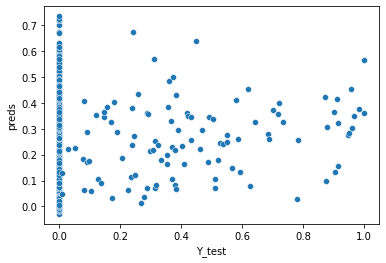

In [23]:
# Calculate RMSE on Test data

preds = model.predict(X_test)
rmse = math.sqrt(mean_squared_error(Y_test, preds))
print(rmse)

Error% for Non-zero values: 0.7370


<AxesSubplot:xlabel='Y_test_cat', ylabel='preds'>

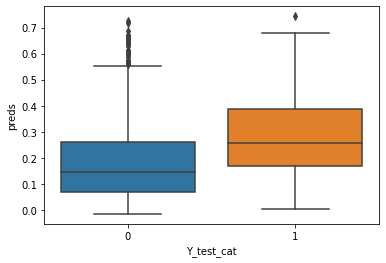

In [109]:
# Plot range of predictions for Null and Non-null sammples

y_nz = tmp_df[tmp_df['Y_test']!=0]['Y_test']
preds_nz = tmp_df[tmp_df['Y_test']!=0]['preds']
rmse = math.sqrt(mean_squared_error(y_nz, preds_nz))
print("Error% for Non-zero values: {:0.4f}".format((rmse/y_nz.mean())))

tmp_df['Y_test_cat'] = np.where(tmp_df['Y_test']==0, 0, 1)
sns.boxplot(data=tmp_df, x='Y_test_cat', y='preds')

## -------------------------------------

# Predicting Diabetes

In [24]:
# Preprocessing

data = orig_data.copy()

data['days'] = data['Type_2_Diabetes_DX_Date_[d_from_CT]']

data['BMI_>30'] = np.where(data['BMI_>30']=='Y', 1, 0)
data.rename(columns={'BMI_>30':'BMI_more_than_30'}, inplace=True)
data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

data['Alcohol_abuse'] = np.where(data['Alcohol_abuse'].isna(),0,1)

col = 'FRS_10-year_risk_(%)'
data[col] = data[col].astype(str)
data[col] = data[col].str.replace('X','')
data[col] = data[col].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data[col] = data[col].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)
med = data[col].median()
data[col] = data[col].fillna(med)
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)

for col in ['FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)']:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace('_','')
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].astype(float)
    med = data[col].median()
    data[col] = data[col].fillna(med)
    upper_limit = data[col].quantile(0.95)
    data[col] = data[col].clip(upper_limit)

data['Met_Sx'] = np.where(data['Met_Sx']=='Y', 1, np.where(data['Met_Sx']=='N', 0, -1))


data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['MI'] = np.where(data['MI_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)

data['diabetes'] = np.where(data['Type_2_Diabetes_DX'].isna(), 0, 1)

data['L1_HU_BMD'] = data['L1_HU_BMD'].clip(lower=0)
data['TAT/Body_Area'] = data['TAT_Area_(cm2)']/data['Total_Body_Area_EA_(cm2)']
col = 'VAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'SAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'VAT/SAT_Ratio'
upper_limit = data[col].quantile(0.95)
data[col] = data[col].clip(upper_limit)

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())
                          
for col in ['BMI','L1_HU_BMD','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
            'VAT/SAT_Ratio','Muscle_HU','Muscle_Area_(cm2)','L3_SMI_(cm2/m2)','TAT/Body_Area']:
    data[col] = data[col].fillna(data[col].median())

In [25]:
# Subsetting to columns in consideration

cols = ['Record_ID', 'BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
       'days', 'CVD', 'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

data = data[cols].copy()
print(data.isna().sum())

Record_ID                                  0
BMI                                        0
BMI_more_than_30                           0
Sex                                        0
Age_at_CT                                  0
Tobacco                                    0
Alcohol_abuse                              0
FRS_10-year_risk_(%)                       0
FRAX_10y_Fx_Prob_(Orange-w/_DXA)           0
FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)       0
Met_Sx                                     0
days                                    6687
CVD                                        0
Heart_failure                              0
MI                                         0
diabetes                                   0
L1_HU_BMD                                  0
TAT_Area_(cm2)                             0
Total_Body_Area_EA_(cm2)                   0
TAT/Body_Area                              0
VAT_Area_(cm2)                             0
SAT_Area_(cm2)                             0
VAT/SAT_Ra

In [26]:
# Creating "Recency" column

data = data[~(data['days']<0)]
data['days_recency'] = np.where(data['days']==0, 1,
                              np.where(data['days']>0, 1/data['days'],
                                       0))

In [28]:
# Creating Train and Test Data

train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]
print(train.shape)
print(test.shape)

(6853, 29)
(1711, 29)


(5328, 29)
(1525, 29)


/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


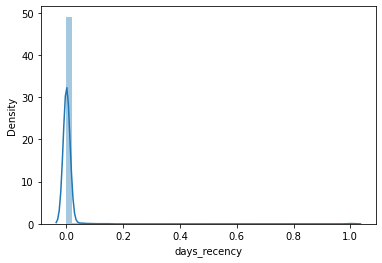

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


18.586854535079983
0.24659985220728195


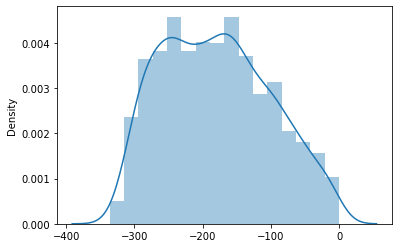

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


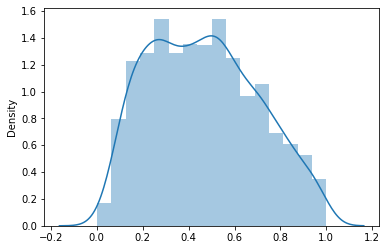

(1525, 29) (1525, 29) (3050, 29)


/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='days_recency', ylabel='Density'>

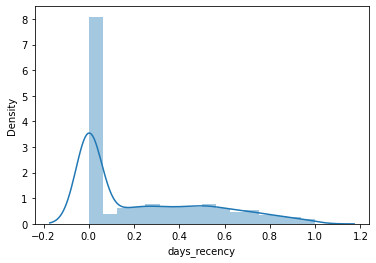

In [29]:
# Train Data: Applying Box-cox transform and Undersampling

col = 'days_recency'
train.sort_values(by=col, inplace=True)
train_1 = train[train[col].cumsum()==0]
train_2 = train[train[col].cumsum()>0]
print(train_1.shape)
print(train_2.shape)

from scipy import stats
X = train_2[col].copy()
sns.distplot(X)
plt.show()
print(pd.Series(X).skew())
X, paras = stats.boxcox(X)
print(pd.Series(X).skew())
sns.distplot(X)
plt.show()
X_mn = X.min()
X_mx = X.max()
Y = (X - X_mn)/(X_mx - X_mn)
sns.distplot(Y)
plt.show()
train_2[col] = Y

train_1_1 = train_1.sample(train_2.shape[0])
train = pd.concat([train_1_1, train_2], ignore_index=True)
train.reset_index(drop=True, inplace=True)
print(train_1_1.shape, train_2.shape, train.shape)
sns.distplot(train[col])

(1359, 29)
(352, 29)
(1359, 29) (352, 29) (1711, 29)


/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with 

<AxesSubplot:xlabel='days_recency', ylabel='Density'>

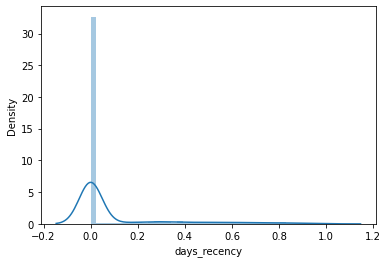

In [30]:
# Test Data: Applying Box-cox transform using parameters of Train

col = 'days_recency'
test.sort_values(by=col, inplace=True)
test_1 = test[test[col].cumsum()==0]
test_2 = test[test[col].cumsum()>0]
print(test_1.shape)
print(test_2.shape)
X = test[col].copy()
X = test_2[col].copy()
X = stats.boxcox(X, paras)
X_mn = X.min()
X_mx = X.max()
Y = (X - X_mn)/(X_mx - X_mn)
test_2[col] = Y
test = pd.concat([test_1, test_2], ignore_index=True)
test.reset_index(drop=True, inplace=True)
print(test_1.shape, test_2.shape, test.shape)
sns.distplot(test[col])

In [38]:
type_of_feats = 'CT_and_clinical'

if type_of_feats=='only_CT':
    feats = ['L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']
else:
    feats = ['BMI', 'BMI_more_than_30',
       'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)',
       'FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CVD',
       'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']
    
# Define Label
label = 'days_recency'

(3050, 12) (3050,)
(1711, 12) (1711,)


In [ ]:
# Create Train and Test numpy arrays

X_train = train[feats].values
Y_train = train[label].values
X_test = test[feats].values
Y_test = test[label].values
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

### Linear Regression

In [39]:
model = LinearRegression().fit(X_train, Y_train)

### SVR

In [41]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

### XGBoost

In [43]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]
model = xgb.XGBRegressor(n_estimators=500, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
model.fit(X_train, Y_train, eval_metric='rmse', eval_set=eval_set)

[0]	validation_0-rmse:0.38935	validation_1-rmse:0.45753
[1]	validation_0-rmse:0.38710	validation_1-rmse:0.45507
[2]	validation_0-rmse:0.38488	validation_1-rmse:0.45265
[3]	validation_0-rmse:0.38269	validation_1-rmse:0.45025
[4]	validation_0-rmse:0.38053	validation_1-rmse:0.44789
[5]	validation_0-rmse:0.37840	validation_1-rmse:0.44557
[6]	validation_0-rmse:0.37631	validation_1-rmse:0.44326
[7]	validation_0-rmse:0.37416	validation_1-rmse:0.44091
[8]	validation_0-rmse:0.37212	validation_1-rmse:0.43867
[9]	validation_0-rmse:0.37003	validation_1-rmse:0.43638
[10]	validation_0-rmse:0.36799	validation_1-rmse:0.43414
[11]	validation_0-rmse:0.36595	validation_1-rmse:0.43195
[12]	validation_0-rmse:0.36394	validation_1-rmse:0.42972
[13]	validation_0-rmse:0.36196	validation_1-rmse:0.42757
[14]	validation_0-rmse:0.36000	validation_1-rmse:0.42543
[15]	validation_0-rmse:0.35807	validation_1-rmse:0.42333
[16]	validation_0-rmse:0.35615	validation_1-rmse:0.42125
[17]	validation_0-rmse:0.35428	validation

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[28]	validation_0-rmse:0.33574	validation_1-rmse:0.39840
[29]	validation_0-rmse:0.33414	validation_1-rmse:0.39667
[30]	validation_0-rmse:0.33264	validation_1-rmse:0.39494
[31]	validation_0-rmse:0.33117	validation_1-rmse:0.39323
[32]	validation_0-rmse:0.32968	validation_1-rmse:0.39151
[33]	validation_0-rmse:0.32811	validation_1-rmse:0.38984
[34]	validation_0-rmse:0.32657	validation_1-rmse:0.38821
[35]	validation_0-rmse:0.32517	validation_1-rmse:0.38659
[36]	validation_0-rmse:0.32380	validation_1-rmse:0.38499
[37]	validation_0-rmse:0.32232	validation_1-rmse:0.38340
[38]	validation_0-rmse:0.32094	validation_1-rmse:0.38181
[39]	validation_0-rmse:0.31949	validation_1-rmse:0.38026
[40]	validation_0-rmse:0.31818	validation_1-rmse:0.37871
[41]	validation_0-rmse:0.31689	validation_1-rmse:0.37720
[42]	validation_0-rmse:0.31559	validation_1-rmse:0.37569
[43]	validation_0-rmse:0.31422	validation_1-rmse:0.37419
[44]	validation_0-rmse:0.31287	validation_1-rmse:0.37274
[45]	validation_0-rmse:0.31162	

[171]	validation_0-rmse:0.23112	validation_1-rmse:0.28146
[172]	validation_0-rmse:0.23090	validation_1-rmse:0.28119
[173]	validation_0-rmse:0.23063	validation_1-rmse:0.28090
[174]	validation_0-rmse:0.23032	validation_1-rmse:0.28063
[175]	validation_0-rmse:0.23011	validation_1-rmse:0.28038
[176]	validation_0-rmse:0.22985	validation_1-rmse:0.28010
[177]	validation_0-rmse:0.22961	validation_1-rmse:0.27982
[178]	validation_0-rmse:0.22930	validation_1-rmse:0.27957
[179]	validation_0-rmse:0.22903	validation_1-rmse:0.27929
[180]	validation_0-rmse:0.22881	validation_1-rmse:0.27904
[181]	validation_0-rmse:0.22857	validation_1-rmse:0.27877
[182]	validation_0-rmse:0.22832	validation_1-rmse:0.27850
[183]	validation_0-rmse:0.22812	validation_1-rmse:0.27827
[184]	validation_0-rmse:0.22791	validation_1-rmse:0.27801
[185]	validation_0-rmse:0.22767	validation_1-rmse:0.27774
[186]	validation_0-rmse:0.22744	validation_1-rmse:0.27750
[187]	validation_0-rmse:0.22717	validation_1-rmse:0.27727
[188]	validati

[313]	validation_0-rmse:0.20931	validation_1-rmse:0.26185
[314]	validation_0-rmse:0.20927	validation_1-rmse:0.26180
[315]	validation_0-rmse:0.20919	validation_1-rmse:0.26175
[316]	validation_0-rmse:0.20909	validation_1-rmse:0.26171
[317]	validation_0-rmse:0.20904	validation_1-rmse:0.26166
[318]	validation_0-rmse:0.20894	validation_1-rmse:0.26161
[319]	validation_0-rmse:0.20888	validation_1-rmse:0.26156
[320]	validation_0-rmse:0.20876	validation_1-rmse:0.26152
[321]	validation_0-rmse:0.20872	validation_1-rmse:0.26146
[322]	validation_0-rmse:0.20868	validation_1-rmse:0.26141
[323]	validation_0-rmse:0.20863	validation_1-rmse:0.26136
[324]	validation_0-rmse:0.20852	validation_1-rmse:0.26132
[325]	validation_0-rmse:0.20846	validation_1-rmse:0.26129
[326]	validation_0-rmse:0.20841	validation_1-rmse:0.26124
[327]	validation_0-rmse:0.20836	validation_1-rmse:0.26120
[328]	validation_0-rmse:0.20831	validation_1-rmse:0.26115
[329]	validation_0-rmse:0.20826	validation_1-rmse:0.26111
[330]	validati

[455]	validation_0-rmse:0.19973	validation_1-rmse:0.25803
[456]	validation_0-rmse:0.19970	validation_1-rmse:0.25802
[457]	validation_0-rmse:0.19963	validation_1-rmse:0.25802
[458]	validation_0-rmse:0.19957	validation_1-rmse:0.25799
[459]	validation_0-rmse:0.19947	validation_1-rmse:0.25797
[460]	validation_0-rmse:0.19934	validation_1-rmse:0.25795
[461]	validation_0-rmse:0.19925	validation_1-rmse:0.25792
[462]	validation_0-rmse:0.19913	validation_1-rmse:0.25794
[463]	validation_0-rmse:0.19909	validation_1-rmse:0.25793
[464]	validation_0-rmse:0.19903	validation_1-rmse:0.25790
[465]	validation_0-rmse:0.19898	validation_1-rmse:0.25789
[466]	validation_0-rmse:0.19894	validation_1-rmse:0.25789
[467]	validation_0-rmse:0.19882	validation_1-rmse:0.25791
[468]	validation_0-rmse:0.19879	validation_1-rmse:0.25790
[469]	validation_0-rmse:0.19870	validation_1-rmse:0.25790
[470]	validation_0-rmse:0.19858	validation_1-rmse:0.25792
[471]	validation_0-rmse:0.19855	validation_1-rmse:0.25791
[472]	validati

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.00999999978, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

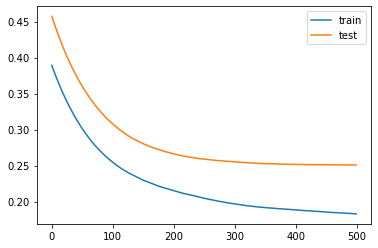

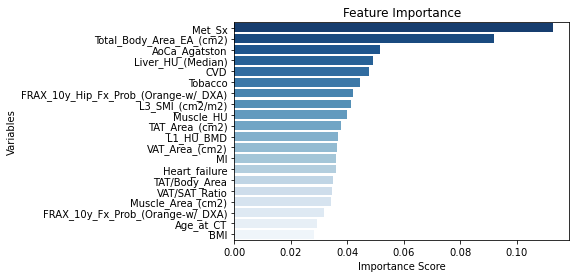

In [121]:
# Plot Training and Test loss while training

results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.show()

In [ ]:
# Plot Feature importance

variables_df = pd.DataFrame(feats, columns=['Variables'])
importance_score_df = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
feature_imp = pd.concat([variables_df, importance_score_df], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
feature_imp = feature_imp.reset_index()
x = 'Importance Score'
y = 'Variables'
sns.barplot(x=x, y=y, data=feature_imp[:20], orient="h", palette="Blues_r")
plt.title('Feature Importance')
plt.show()

0.2577337800467796 0.09387453075643284


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

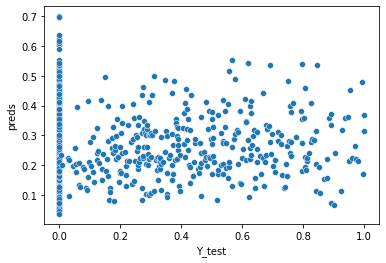

In [44]:
# Calculate RMSE on Test data

preds = model.predict(X_test)
rmse = math.sqrt(mean_squared_error(Y_test, preds))
print(rmse)

Error% for Non-zero values: 0.6907


<AxesSubplot:xlabel='Y_test_cat', ylabel='preds'>

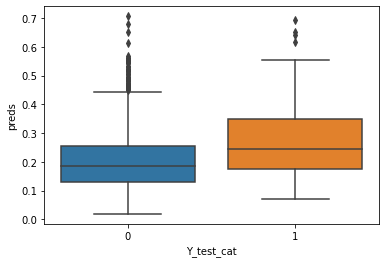

In [123]:
# Plot range of predictions for Null and Non-null sammples

y_nz = tmp_df[tmp_df['Y_test']!=0]['Y_test']
preds_nz = tmp_df[tmp_df['Y_test']!=0]['preds']
rmse = math.sqrt(mean_squared_error(y_nz, preds_nz))
print("Error% for Non-zero values: {:0.4f}".format((rmse/y_nz.mean())))

tmp_df['Y_test_cat'] = np.where(tmp_df['Y_test']==0, 0, 1)
sns.boxplot(data=tmp_df, x='Y_test_cat', y='preds')
